In [1]:
projectdir = "C:/Users/arman/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia/"
cd(projectdir)
using Pkg; Pkg.activate(pwd())

using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings, LsqFit, CSV, Pipe, ProgressMeter, StatsPlots
using Distributions, NLsolve, Roots
pyplot()

try 
    Turnover
catch e
    include(projectdir*"Turnover/src/Turnover.jl")
    include(projectdir*"Turnover/src/test.jl")
    using .Turnover
end
try
    SeqDataFormatting
catch e
    include("experimental_data/SeqDataFormatting.jl")
    using .SeqDataFormatting
end

import TumorGrowth
include("distribution_functions.jl")
plot(size=(1,1))

  Activating environment at `C:\Users\arman\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`

Test Summary:             | Pass  Total
Applying turnover methods |    7      7


# Experimental Data

In [2]:
mes2theory_orphaned(t_mes, p = [0.188, 17.688]) = @. p[1]*( 1/(1+exp(-p[2]*t_mes)) -1/2 )
# # mes2theory_orphaned(t_mes, p = [-0.264, 2.649]) = @. p[1] + p[2]*t_mes

mes2theory_estranged(t_mes, p = [0.603, 1.267]) = map(t_mes) do t
# mes2theory_estranged(t_mes, p = [0.804, 1.613]) = map(t_mes) do t
    if p[1]/p[2] > 1/2 
        10
    else
        t >= p[1] ? 1. : log( 1/ ( t*1/p[2] + 1/2 ) - 1 ) / log( 1/ ( p[1]/p[2] + 1/2 ) - 1)
    end
end

mes2theory_estranged (generic function with 2 methods)

In [3]:
function bisection(f, interval, iter; precision=1e-9)
    xlow, xup = interval
    sign(f(xlow)) == sign(f(xup)) && error("no zero in interval $interval")
    any((isnan.(f.(interval)))) && error("f not defined on interval $interval")
    for i=1:iter
        xm = (xlow+xup)/2
        abs(f(xm)) < precision && return (xm, i)
        if sign(f(xm)) != sign(f(xlow))
            xup = xm
        else
            xlow = xm
        end
    end
    println(xup)
    error("no convergence within $iter steps")
end

bisection (generic function with 1 method)

In [2]:
function load_turnovertumors!(tumor; Nthresh_orph = 10000, Nthresh_estr = Nthresh_orph)
    mutations, freqs = SeqDataFormatting.mfreqs(tumor) |> df -> (df.mutation, Dict( df.mutation .=> df.frequency ))
    htypes = unique(tumor.mutations)
    orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/Nthresh_orph, htypes) ) )
    estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/Nthresh_estr for m in muts), htypes) )
    (orphaned_tumor = orphaned_tumor, estranged_tumor = estranged_tumor)
end
load_turnovertumors(tumor; kwrgs...) = load_turnovertumors!(deepcopy(tumor); kwrgs...)

load_turnovertumors (generic function with 1 method)

## Reanalyzed data (joint caller)

In [3]:
sampleinfo = TumorGrowth.data_import("experimental_data/wes_sampleinfo.csv", delim=",")
normal = "N1"
tumorsamples = sampleinfo.samplename
samples = [tumorsamples..., normal]

# mutations_string = CSV.read("experimental_data/MichelProcessed/Ling2015_pairwise_median.csv", DataFrame)
# mutations_string = CSV.read("experimental_data/MichelProcessed/Ling2015_jointcall.csv", DataFrame)
mutations_string = (DataFrame ∘ CSV.File)("experimental_data/MichelProcessed/Ling2015_jointcall_pwrecovered.csv")
# mutations_string = (DataFrame ∘ CSV.File)("experimental_data/MichelProcessed/Ling2015_pw2joint_intersect.csv")

seqdata = SeqDataFormatting.string_to_seqresult(mutations_string, samples);

In [4]:
ccf_raw = seqdata_to_tumor(seqdata, sampleinfo; normal = "N1", 
    maxReadsNormal = 0, 
    minReads = 5,
    minTotCoverage = 150,
    cnaAgreement = 0,
    allow_xy = true,
    cutoff_hi = 0.5,
    )
ccf_raw.frequencies = copy(ccf_raw.ccf);
vcat(ccf_raw.mutations...) |> unique |> length

282

In [162]:
# ccf_raw = TumorGrowth.data_import("experimental_data/LingProcessed/experimental_data_WES.csv"; delim="\t")
# ccf_raw.frequencies = copy(ccf_raw.ccf);

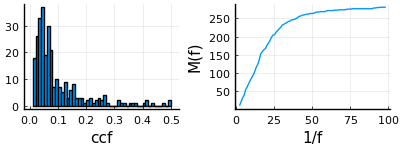

In [5]:
include("distribution_functions.jl")
mutations, freqs = SeqDataFormatting.mfreqs(ccf_raw) |> df -> (df.mutation, Dict( df.mutation .=> df.frequency ))

res = 1/100
plot( 
    histogram(filter( f-> 1. > f > res, [freqs[m] for m=mutations]), nbins=50, lab="", xlab=:ccf),
    M(filter( f-> 1. > f > res, [freqs[m] for m=mutations]), nbins=50, lab=""),
    size=(400,150)
)

#### PARAMETERS

In [71]:
# turnover_params = ( Nthresh_orph = 35, Nthresh_estr = 15, )
turnover_params = ( f_min = 1/10, Nthresh_orph = 90, Nthresh_estr = 90, )

filter_params =  (cutoff_low = 1/100, sample_cutoff_low = 3/4, )
mutnumb = 40

ccf = deepcopy(ccf_raw)
freqs = SeqDataFormatting.mfreqs(ccf) |> df -> Dict(df.mutation .=> df.frequency)
filter_by_freq!(ccf; filter_params...)
subsample!(ccf; nmuts = mutnumb)

htypes = unique(ccf.mutations)
orphaned_tumor = DataFrame( mutations = unique( 
    filter.(m-> freqs[m] > turnover_params[:f_min], htypes) ) )
estranged_tumor = DataFrame(mutations = filter( 
    muts -> all(  freqs[m] > turnover_params[:f_min] for m in muts), htypes) )

vcat(orphaned_tumor.mutations...) |> unique |> length |> println
vcat(estranged_tumor.mutations...) |> unique |> length |> println

23
17


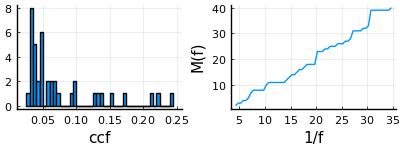

In [72]:
include("distribution_functions.jl")
mutations, freqs = SeqDataFormatting.mfreqs(ccf) |> df -> (df.mutation, Dict( df.mutation .=> df.frequency ))

res = 1/100
plot( 
    histogram(filter( f-> 1. > f > res, [freqs[m] for m=mutations]), nbins=50, lab="", xlab=:ccf),
    M(filter( f-> 1. > f > res, [freqs[m] for m=mutations]), nbins=50, lab=""),
    size=(400,150)
)

### single tumor

0.14 d: 0.8049287999165591


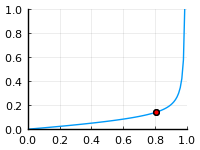

In [73]:
# get d
W_l = orphaned_red_treeless(orphaned_tumor) |>
        df -> sum(df.isorphaned)/sum(df.isgreen)
W_l_corrected = W_l  #|> mes2theory_orphaned

d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; 
            N= turnover_params[:Nthresh_orph] * (1-x))) - W_l,
            0.01, 0.99) 

println(W_l_corrected, " d: ", d_solve)

plot(0.0:0.01:1., d-> W_orphaned(d; N = turnover_params[:Nthresh_orph]*(1-d))
    , size=(200,150), xlim=(0,1), ylim=(0,1), lab="")
scatter!([d_solve], [W_l], lab="", c=:red)
scatter!([d_solve], [W_l_corrected], lab="", c=:red)

W_c: 0.8571428571428571 mu: 0.17917933647341233


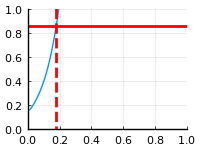

In [74]:
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum(df.isestranged)/sum(df.isgreen)
mu_solve = try
    fzero(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, 
                T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, eps(), 1-eps())
    catch e
        NaN
end
println("W_c: ", W_c, " mu: ", mu_solve)

plot(0.0:0.01:1., mu-> W_estranged(d_solve; b=1, μ=mu, 
        T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)),
    size=(200,150), xlim=(0,1), ylim=(0,1), lab="")
hline!([W_c], lab="", c=:red, lw=2)
vline!([mu_solve], lab="", c=:red, lw=2, style=:dash)

In [75]:
# get mu
Ls = 0.2:0.1:1.
reps = 100
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, map(set) do tumor
            res = estranged_treeless(tumor)
            sum(res.isestranged)/sum(res.isgreen) #|> mes2theory_estranged
        end )
    end

Ls, estranged_turnover = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1, μ=mu*L, 
                T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))
    end
end

fitres = curve_fit(model, Ls, mean.(estranged_turnover), [(1-d_solve)/2])
mu_fit = fitres.param[1]

0.21475241815925747

mean fit : 0.21475241815925747
averaged fits : 0.2592132172453273 ± 0.0077047001372479666


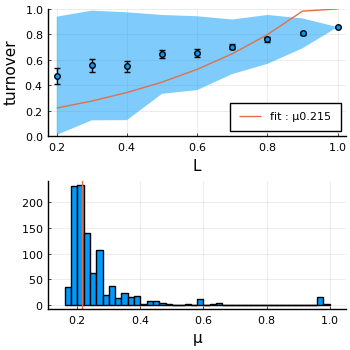

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [76]:
let d = d_solve
    t = estranged_turnover
    global Nthresh
    function model(Ls, p)
        local mu = p[1]
        (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=1., μ=mu*L, 
                    T=log(turnover_params[:Nthresh_estr]*(1-d))/(1-d)))
        end
    end
    fit = curve_fit(model, Ls, mean.(t), [(1-d)/2])
    mu_fit = fit.param[1]

    p1 = scatter(Ls, mean.(t), ribbon=std.(t), yerror = std.(t)./sqrt.(length.(t)), lab="", xlab=:L, ylab=:turnover, legend=:bottomright, ylim=(0,1))
    plot!(Ls, model(Ls, fit.param), lab="fit : μ$(round(mu_fit,digits=3))" )

    tvecs = [ rand.(t) for _=1:1000 ]
    fits = map( tp-> curve_fit(model, Ls, tp, [(1-d)/2]), tvecs)
    mu_fits = getindex.(getfield.(fits, :param),1)
    p2 = histogram(mu_fits, xlab="μ", lab="")
    vline!([mu_fit], lab="")

    println("mean fit : ", mu_fit)
    println("averaged fits : ", mean(mu_fits), " ± ", 1.96*std(mu_fits)/sqrt(length(mu_fits)))
    plot(p1, p2, layout=(2,1), size=(350,350))
end

mean fit : 0.4751729766333367
averaged fits : 0.5239440814267328 ± 0.010803534175947413


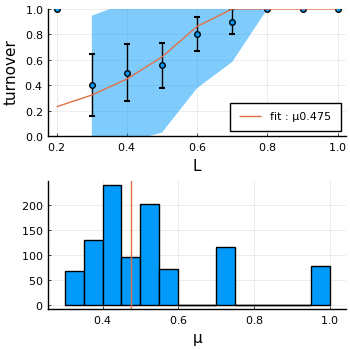

In [62]:
let d = d_solve
    t = estranged_turnover
    global Nthresh
    function model(Ls, p)
        local mu = p[1]
        (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=1., μ=mu*L, 
                    T=log(turnover_params[:Nthresh_estr])/(1-d)))
        end
    end
    fit = curve_fit(model, Ls, mean.(t), [(1-d)/2])
    mu_fit = fit.param[1]

    p1 = scatter(Ls, mean.(t), ribbon=std.(t), yerror = std.(t)./sqrt.(length.(t)), lab="", xlab=:L, ylab=:turnover, legend=:bottomright, ylim=(0,1))
    plot!(Ls, model(Ls, fit.param), lab="fit : μ$(round(mu_fit,digits=3))" )

    tvecs = [ rand.(t) for _=1:1000 ]
    fits = map( tp-> curve_fit(model, Ls, tp, [(1-d)/2]), tvecs)
    mu_fits = getindex.(getfield.(fits, :param),1)
    p2 = histogram(mu_fits, xlab="μ", lab="")
    vline!([mu_fit], lab="")

    println("mean fit : ", mu_fit)
    println("averaged fits : ", mean(mu_fits), " ± ", 1.96*std(mu_fits)/sqrt(length(mu_fits)))
    plot(p1, p2, layout=(2,1), size=(350,350))
end

In [63]:
d_solve, mu_fit

(0.7823507976168007, 0.21283386628950685)

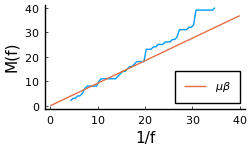

In [80]:
mutations, freqs = SeqDataFormatting.mfreqs(ccf) |> df -> (df.mutation, Dict( df.mutation .=> df.frequency ))

M([freqs[m] for m=mutations], nbins=50, lab="", size=(250,150), grid=false)
plot!(0:40, x-> x*mu_solve/(1-d_solve), lab=L"\mu \beta", legend=:bottomright)

## Subsampling single tumor

In [69]:
# offspring_clade_fit, orphaned_clade_fit = [-3.1393344953000137, 0.3694065504550832], [0.28213233319606085, 0.9337963349045757]
# offspring_clone_fit, estranged_clone_fit = [2.0460394588109088, 0.27062540749285335], [1.742873794475777, 0.3815998563513362]

# n 30, Nthresh_orph 200, Nthresh_estr 50, res 1/200, 1/3

offspring_clade_fit, orphaned_clade_fit, offspring_clone_fit, estranged_clone_fit = [0,1],[0,1],[0,1],[0,1]

function correct_orph(df_orph, p = [offspring_clade_fit, orphaned_clade_fit])
    max(0, sum(df_orph.isorphaned)- p[2][1]) / p[2][2] / (sum(df_orph.isgreen) - p[1][1]) * p[1][2]
end
function correct_estr(df_estr, p = [offspring_clone_fit, estranged_clone_fit])
    max(0, sum(df_estr.isestranged)- p[2][1]) / p[2][2] / (sum(df_estr.isgreen) - p[1][1]) * p[1][2]
end

correct_estr (generic function with 2 methods)

### relative death rate $d/b$

0.11545637777739783
89 %


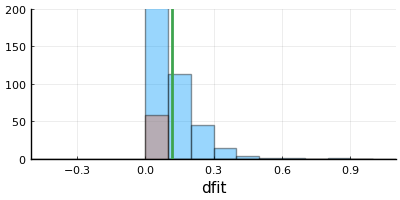

In [190]:
let mutnumb = 30
    dsolves = map(1:500) do _
        
        ccf = deepcopy(ccf_raw)
        filter_by_freq!(ccf; filter_params...)
        subsample!(ccf; nmuts = mutnumb)
        orphaned_tumor, estranged_tumor = load_turnovertumors(ccf; turnover_params...)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor)  |> df -> sum(df.isorphaned)/sum(df.isgreen)

        min(1., 2*log(turnover_params[:Nthresh_orph])*W_l)
    end
    histogram(dsolves, legend=:none, size=(400,200), alpha=0.4, bins=0:0.1:1, xlim=(-0.5,1.1), ylim=(0,200), xlab=:dfit)
    histogram!(filter(x-> !(1>x>0), dsolves), legend=:none, size=(400,200), bins = -1:0.1:2, alpha=0.4)
    results = filter(x-> 1>x>0, dsolves)
    vline!([mean(results)], lw=2.)
    println(mean(results))
    println(ceil(Int, length(results)/length(dsolves)*100 ), " %")
    plot!()
end

> uncorrected

In [191]:
d_solve = 0.15
1/(1-d_solve)

1.1764705882352942

### mutation rate $\mu$

### *fit*

0.9700892092616253
100 %


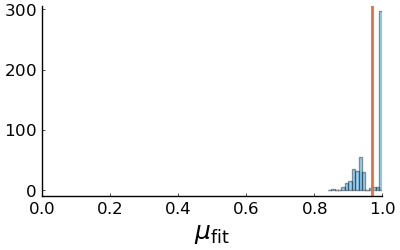

In [192]:
let mutnumb = 30
    mufits = map(1:500) do _
        
        ccf = deepcopy(ccf_raw)
        filter_by_freq!(ccf; filter_params...)
        subsample!(ccf; nmuts = mutnumb)
        
        # get mu

        Ls = 0.3:0.1:1.
        reps = 10
        estranged_tumors = map( Ls ) do L
            [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
        end

        estranged_turnover = map(estranged_tumors) do set
                filter!(!isnan, map(set) do tumor
                    estranged_treeless(tumor) |>  df -> sum(df.isestranged)/sum(df.isgreen)
                    end ) 
            end

        Ls, estranged_turnover = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])
        if isempty(Ls)
            missing
        else
            function model(Ls, p)
                local mu = p[1]
                (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
                map( Ls ) do L
                    min(1., W_estranged(d_solve; b=1, μ=mu*L, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))
                end
            end

            fitres = curve_fit(model, Ls, mean.(estranged_turnover), [(1-d_solve)/2])
            fitres.param[1] ≈ (1-d_solve)/2 ? 1. : fitres.param[1]
        end
    end
    filter!(!ismissing, mufits)
    histogram(mufits, legend=:none, size=(400,250), nbins=20, alpha=0.4, xlim=(0,1), xlab=L"\mu_{\mathrm{fit}}", tickfontsize=12, labelfontsize=18, grid=false)
    results = filter(x-> !(iszero(x) || isone(x)), mufits)
    vline!([mean(results)], lw=2.)
    println(mean(results))
    println(ceil(Int, length(results)/length(mufits)*100 ), " %")
    plot!()
end

> uncorrected

### *solve*

0.7579513978967635
27 %


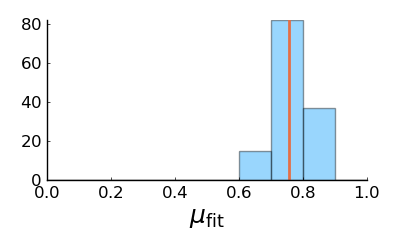

In [193]:
let mutnumb = 30
    mufits = map(1:500) do _
        
        ccf = deepcopy(ccf_raw)
        filter_by_freq!(ccf; filter_params...)
        subsample!(ccf; nmuts = mutnumb)
        orphaned_tumor, estranged_tumor = load_turnovertumors(ccf; turnover_params...)
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> df -> sum(df.isestranged)/sum(df.isgreen)
    
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)
        catch e
            0.99
        end
                
    end
    
    results = filter(x-> !(x == 0.01 || x == 0.99), mufits)
    histogram(results, legend=:none, size=(400,250), alpha=0.4, xlim=(0,1), xlab=L"\mu_{\mathrm{fit}}",
        tickfontsize=12, labelfontsize=18, grid=false, ylims=(0,:auto), margin=5Plots.mm, bins=0:0.1:1.)
    vline!([mean(results)], lw=2.)
    println(mean(results))
    println(ceil(Int, length(results)/length(mufits)*100 ), " %")
    plot!()
end

In [106]:
d_solve

0.8

In [111]:
d_solve = 0.8
mu_solve = 0.14
mu_solve/(1-d_solve)

0.7000000000000002

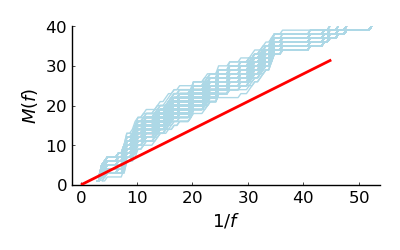

In [112]:
let mutnumb = 40
    fig = plot(size=(400,250), legend=:none, tickfontsize=12, labelfontsize=13, grid=false, ylims=(0,:auto), margin=5Plots.mm)
    for _=1:200
        ccf = deepcopy(ccf_raw)
        filter_by_freq!(ccf; filter_params...)
        subsample!(ccf; nmuts = mutnumb)

        mutations, freqs = SeqDataFormatting.mfreqs(ccf) |> df -> (df.mutation, Dict( df.mutation .=> df.frequency ))

        M!(fig, [freqs[m] for m=mutations], nbins=50, lab="", size=(400,250), res=1/300, c=:lightblue, xlab=L"1/f", ylab=L"M(f)")
        
    end
    plot!(0:1/filter_params[:cutoff_low], x-> x*mu_solve/(1-d_solve), lab=L"\mu \beta", lw=2., c=:red)
end